In [4]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn
from torch.nn import functional as F
#import tqdm
from src import models, utils#, parametrizations,tasks,running#,tasks
import os 

%load_ext autoreload
%autoreload 2

plt.rcParams.update({
    'font.size': 16,  # Update global font size
    'axes.titlesize': 20,  # Update axes title font size
    'axes.labelsize': 10,  # Update axes label font size
    'xtick.labelsize': 12,  # Update xtick label font size
    'ytick.labelsize': 12,  # Update ytick label font size
})
plt.style.use("dark_background")

In [5]:

def generate_sine_waves(n, T, frequency=1, time_step=0.01):
    t = np.arange(0, T, time_step)
    matrix = np.zeros((n, len(t)))

    for i in range(n):
        amplitude = np.random.uniform(0.5, 1.0)
        phase = np.random.uniform(0, 2 * np.pi)
        matrix[i, :] = amplitude * np.sin(2 * np.pi * frequency * t + phase)

    return t, matrix

  


def plot_simulation_results(t, sine_waves, state):
    n = sine_waves.shape[0]
    
    plt.figure(figsize=(10, 5))
    for i in range(n):
        plt.plot(t, sine_waves[i, :], label=f'Input sine wave {i+1}')
    plt.xlabel('Time')
    plt.ylabel('Amplitude')
    plt.title('Sine waves input')
    plt.legend()
    plt.show()

    plt.figure(figsize=(10, 5))
    for i in range(n):
        plt.plot(t, state[i, :], label=f'State {i+1}')
    plt.xlabel('Time')
    plt.ylabel('Amplitude')
    plt.title('System state')
    plt.legend()
    plt.show()



In [6]:
def generate_random_hierarchcal_adjacency(p, s):
    # p number of nodes
    # s sparsity

    A = np.random.choice([0,1],p = [s, 1-s],size = (p,p))
    return np.tril(A) - np.diag(np.diag(A))

In [328]:
class GW_Net:
    def __init__(self, hidden_size = 32, p = 5, g = 1.5, s_max = 1, arch = 'all'):
        self.hidden_size = hidden_size
        self.p = p
        self.g = g 
        self.s_max = s_max
        self.arch = arch
        self.build_GW_Net()
        
        
    def build_GW_Net(self):
        # hidden_size = number of units per subnetwork
        # p = number of subnetworks
        # g = initial recurrent magnitude for h2h matrices
        # s_max = largest singular value of h2h matrices

        ns = [self.hidden_size for _ in range(self.p)]

        if self.arch == 'GW':
            A_tril = torch.zeros((len(ns), len(ns)))
            A_tril[-1, :] = 1
            B_mask = utils.create_mask_given_A(A_tril, ns)
            B = B_mask.detach().cpu().numpy()
            B = (B + B.T)
            B[B == 2] = 0
            
            
        if self.arch == 'hier':
            A_tril = generate_random_hierarchcal_adjacency(self.p, 0)
            B_mask = utils.create_mask_given_A(A_tril, ns)
            B = B_mask.detach().cpu().numpy()
           
        if self.arch == 'all':
            A_tril = np.ones((self.p,self.p)) - np.eye(self.p)
            B_mask = utils.create_mask_given_A(A_tril, ns)
            B = B_mask.detach().cpu().numpy()
            B = (B + B.T)

        if self.arch == 'random':
            A_tril = np.random.choice([0,1],p = [0.2, 0.8],size = (self.p,self.p)) - np.eye(self.p)
            B_mask = utils.create_mask_given_A(A_tril, ns,use_upper = True)
            B = B_mask.detach().cpu().numpy()



        # adaptable weights
        A = np.eye(int(self.hidden_size*self.p))#np.random.normal(0,1/np.sqrt(hidden_size),(sum(ns),sum(ns)))
        A = A*B

        # intra-areal weights, singular values less than or equal to unity
        blocks = utils.create_mask_given_A(np.eye(len(ns)), ns)
        blocks = blocks.detach().cpu().numpy()
        W = np.random.normal(0,self.g/np.sqrt(self.hidden_size),(sum(ns),sum(ns)))
        W *= blocks

        # sparsify h2h weights
        random_W_mask = np.random.choice([0,1],p = [0.5,0.5],size = (sum(ns),sum(ns)))
        W *= random_W_mask

        # project h2h to unit norm
        u,s,vt = np.linalg.svd(W)
        s = np.minimum(self.s_max,s)
        W = u @ np.diag(s) @ vt

        self.W, self.F, self.A, self.B = W, F, A, B

    def forward(self, x, u):
        # Define the forward computation here
        
        return -x + self.W @ np.maximum(0,x) + self.A @ np.maximum(0,x)  + u

    def __call__(self, x, u):
        return self.forward(x, u)



In [393]:
def run_gp_adaptation(net = None, hidden_size = 32, p = 5, dt = 0.005, T = 150, trials = 1 , eta = 1, gain = 1, sigma = 5, lam = 1):

    n = int(net.hidden_size*net.p)
    ts = np.arange(0, T, dt)


    es = np.zeros((trials,len(ts)))

    for trial in range(trials):

        net.A = np.eye(n)*net.B



        x = 0*np.random.normal(0, 1/np.sqrt(n), n)

        #_, sine_waves = generate_sine_waves(n, T, time_step= dt, frequency = 2)
        u = utils.generate_GP(T = T,time_step = 0.1,n = n,sigma = sigma)
        u = utils.upscale_timeseries(u.T, len(ts))
        u = u.T
        
        #_, sine_waves_desired = generate_sine_waves(n, T, time_step = dt, frequency = 1)
        xs_d = utils.generate_GP(T = T,time_step = 0.1,n = n,sigma = sigma)
        xs_d = utils.upscale_timeseries(xs_d.T, len(ts))
        xs_d = xs_d.T

        
        states = []

        for k, _ in enumerate(ts):
            
            states.append(x)

            e = x - xs_d[:,k]
            es[trial,k] = (1/np.sqrt(n))*np.linalg.norm(e)            

            net.A = net.A + dt*(-lam*net.A -eta*np.outer(e,np.maximum(0,x))*net.B)
            f = net(x, u[:,k] - gain*e)            

            x = x +  dt*f

        states = np.stack(states)
        
    
    return es, states, xs_d, u,ts
    

In [423]:
GW_RNN_Stable = GW_Net(g = 1.5, s_max = 1.0, hidden_size = 16, p = 10, arch = 'hier')

gain_range
sigma_range



es,states,states_desired,u,ts = run_gp_adaptation(net = GW_RNN_Stable, T = 300, dt = 0.1, eta = 1, gain = 5, lam = 0.1, sigma = 5, trials = 1)

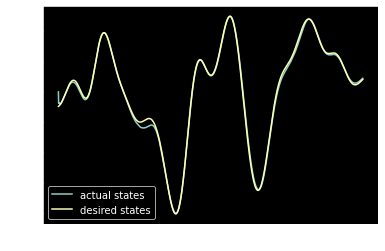

In [424]:
plt.plot(ts,states[:,30],label = 'actual states')
plt.plot(ts,states_desired[30,:],label = 'desired states')
plt.legend()

(0.0, 1.0845971120521183)

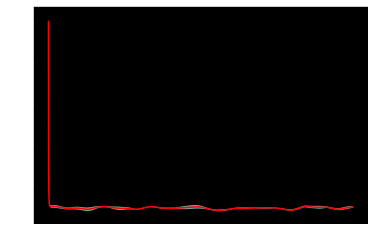

In [425]:
#mean_stable = np.mean(es, axis = 0)
#plt.plot(mean_stable);

mean_e = np.mean(es, axis = 0)
std_e = np.std(es, axis = 0)
standard_error = std_e/np.sqrt(len(es))






plt.plot(ts, mean_e,color = 'r')
plt.fill_between(ts,mean_e - standard_error, mean_e + standard_error, alpha=0.8, label='Standard Deviation')
plt.ylim(0)

In [409]:
mean_e

array([0.97005275, 0.97756416, 0.98957194, ..., 0.42058972, 0.41562804,
       0.4109541 ])